# VGG16 - Using Random Seed 🌱 + Categorical Crossentropy

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import cv2  
import imghdr  # module to determine type or format of image files
import shutil
import random
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications.vgg16 import VGG16, VGG19
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
SEED = 0
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [4]:
# Handle ".DS_Store" issue from class names

def remove_hidden(folder_path: str):
    '''
    This function removes ".DS_Store" from the list to be returned.
    '''

    folder_list = os.listdir(folder_path)

    if ".DS_Store" in folder_list:
        folder_list = folder_list[1:]

    return folder_list

In [5]:
# Handle ".DS_Store" issue

data_dir_path = "/Users/mckishiebombom/code/quekwl/car_damage_assessment/raw_data_01"
data_dir = remove_hidden(data_dir_path)

data_dir

['moderate_damage', 'no_damage', 'severe_damage', 'minor_damage', 'total_loss']

In [6]:
# Remove dodgy images
image_exts = ["jpeg", "jpg", "bmp", "png"]


for image_class in data_dir: 
    for image in os.listdir(os.path.join(data_dir_path, image_class)):
        image_path = os.path.join(data_dir_path, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)   # determine file format
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

libpng warning: iCCP: known incorrect sRGB profile


In [7]:
# Process data

X = []
y = []
size = (224, 224)

class_names = remove_hidden(data_dir_path)

for class_name in class_names:
    class_dir = os.path.join(data_dir_path, class_name)

    # Check if the class_dir is a directory
    if os.path.isdir(class_dir):

        # Iterate through the image files in each class directory
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image = cv2.imread(image_path)
                image = cv2.resize(image, size)
                X.append(image)
                y.append(class_names.index(class_name))
                
X = np.array(X)
y = np.array(y)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

libpng warning: iCCP: known incorrect sRGB profile


Shape of X: (1357, 224, 224, 3)
Shape of y: (1357,)


In [8]:
# class_labels = {
#     'no_damage': 0,
#     'minor_damage': 1,
#     'moderate_damage': 2,
#     'severe_damage': 3,
#     'total_loss': 4
# }
# class_counts = {class_label: 0 for class_label in class_labels.keys()}
# for class_number in y:
#     class_label = list(class_labels.keys())[list(class_labels.values()).index(class_number)]
#     class_counts[class_label] += 1

# # Extract class labels and counts
# class_labels = list(class_counts.keys())
# class_counts = list(class_counts.values())

# # Create the histogram
# plt.figure(figsize=(10, 5))
# plt.bar(class_labels, class_counts)
# plt.xlabel('Class Label')
# plt.ylabel('Number of Images')
# plt.title('Number of Images in Each Class')
# plt.xticks(rotation=45)
# plt.show()

In [9]:
# Shuffle and Split data

# Shuffle data
p = np.random.permutation(len(X))
X, y = X[p], y[p]

# Split data
train_size = int(len(X)*.7)
val_size = int(len(X)*.2)
test_size = int(len(X)*.1)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (949, 224, 224, 3)
X_val shape:  (271, 224, 224, 3)
X_test shape:  (137, 224, 224, 3)


In [10]:
from keras.utils import to_categorical

# Example class labels
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_train = to_categorical(y_train)

In [29]:
# import model without the 3 fully connected layers at the top of the network

model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)

model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# Set the first layers to be untrainable
model_vgg16.trainable = False

model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# Customise VGG16 model

flattening_layer = layers.Flatten()
dense_layer = layers.Dense(224, activation = "relu")
prediction_layer = layers.Dense(5, activation = "softmax")

custom_model_vgg16 = models.Sequential([
        model_vgg16,
        flattening_layer,
        dense_layer,
        prediction_layer
    ])

In [14]:
# Model Summary
custom_model_vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 224)               5619936   
                                                                 
 dense_1 (Dense)             (None, 5)                 1125      
                                                                 
Total params: 20335749 (77.57 MB)
Trainable params: 5621061 (21.44 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [15]:
# Compile model

custom_model_vgg16.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"])

In [16]:
# Fit model

es = EarlyStopping(patience = 5, restore_best_weights = True)
history = custom_model_vgg16.fit(X_train, y_train,
                    epochs = 50,
                    validation_data = (X_val, y_val),
                    batch_size = 16,
                    callbacks = [es])

Epoch 1/50


2023-09-22 10:02:47.257545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - ETA: 0s - loss: 81.4539 - accuracy: 0.6091

2023-09-22 10:02:58.931096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 15s 247ms/step - loss: 81.4539 - accuracy: 0.6091 - val_loss: 55.4264 - val_accuracy: 0.6421
Epoch 2/50
60/60 [==============================] - 14s 239ms/step - loss: 17.6925 - accuracy: 0.8546 - val_loss: 51.9170 - val_accuracy: 0.6421
Epoch 3/50
60/60 [==============================] - 14s 239ms/step - loss: 6.8443 - accuracy: 0.8999 - val_loss: 57.8049 - val_accuracy: 0.6716
Epoch 4/50
60/60 [==============================] - 14s 234ms/step - loss: 3.2059 - accuracy: 0.9473 - val_loss: 49.7747 - val_accuracy: 0.6827
Epoch 5/50
60/60 [==============================] - 14s 237ms/step - loss: 2.6948 - accuracy: 0.9600 - val_loss: 58.0749 - val_accuracy: 0.6716
Epoch 6/50
60/60 [==============================] - 14s 234ms/step - loss: 3.1854 - accuracy: 0.9610 - val_loss: 55.1963 - val_accuracy: 0.7048
Epoch 7/50
60/60 [==============================] - 14s 234ms/step - loss: 1.9936 - accuracy: 0.9768 - val_loss: 54.0647 - val_accuracy: 0.6827
E

In [17]:
# Evaluate model

results = custom_model_vgg16.evaluate(X_test, y_test)
results

5/5 [==============================] - 2s 320ms/step - loss: 54.0357 - accuracy: 0.6569


[54.035675048828125, 0.6569343209266663]

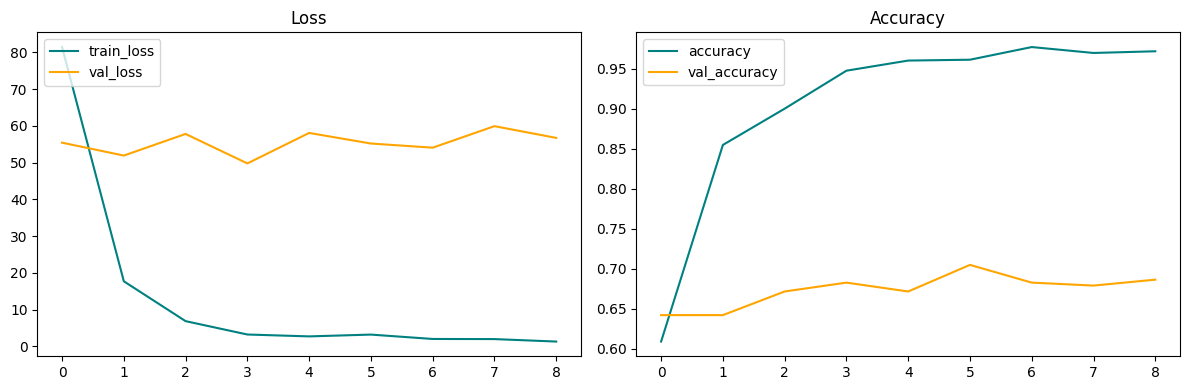

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  

# Subplot 1: Loss
axs[0].plot(history.history["loss"], color="teal", label="train_loss")
axs[0].plot(history.history["val_loss"], color="orange", label="val_loss")
axs[0].set_title("Loss")
axs[0].legend(loc="upper left")

# Subplot 2: Accuracy
axs[1].plot(history.history["accuracy"], color="teal", label="accuracy")
axs[1].plot(history.history["val_accuracy"], color="orange", label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].legend(loc="upper left")

plt.tight_layout()
plt.show()


In [20]:
# Evaluate model

results = custom_model_vgg16.evaluate(X_test, y_test)
results

5/5 [==============================] - 2s 325ms/step - loss: 54.0357 - accuracy: 0.6569


[54.035675048828125, 0.6569343209266663]

In [23]:
# Save model

custom_model_vgg16.save("model_vgg16_sol.h5")

/Users/mckishiebombom/code/quekwl/car_damage_assessment/virtual_env_with_gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
custom_model_vgg16.layers[2].get_weights()

[array([[-1.2688577e-02,  9.2016850e-03, -1.2525143e-02, ...,
         -1.2306382e-02, -1.6624315e-02, -1.1624693e-02],
        [ 1.3462903e-02,  5.5919802e-03,  1.4136991e-02, ...,
         -8.0871982e-03, -1.9060522e-02, -8.9439470e-03],
        [ 3.3655921e-03,  5.0757211e-03, -3.1084117e-05, ...,
         -1.5260139e-03, -8.8721355e-03, -1.9221013e-02],
        ...,
        [ 3.4294613e-03, -8.1311371e-03, -1.7967181e-02, ...,
          4.6823844e-03,  1.3227688e-02, -4.3130373e-03],
        [-3.5981163e-03, -1.5393940e-02,  5.6443796e-03, ...,
         -1.3568841e-02,  5.4200017e-03, -1.8360104e-02],
        [ 2.6887916e-03, -1.1372965e-02, -1.5422274e-02, ...,
          5.9997570e-03, -1.9465497e-02,  1.1876946e-02]], dtype=float32),
 array([-0.00823034, -0.00805613, -0.00581017, -0.00418561, -0.00229388,
        -0.01453428, -0.00496   , -0.00340947, -0.00508786, -0.00967457,
        -0.00633285,  0.00227513, -0.00570141, -0.00843369, -0.00600238,
        -0.00375251,  0.0096677

31
['moderate_damage', 'no_damage', 'severe_damage', 'minor_damage', 'total_loss']
1/1 [==============================] - 0s 186ms/step


2023-09-22 10:05:00.671205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


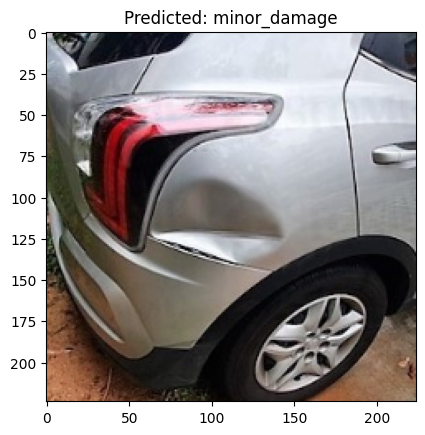

1/1 [==============================] - 0s 18ms/step


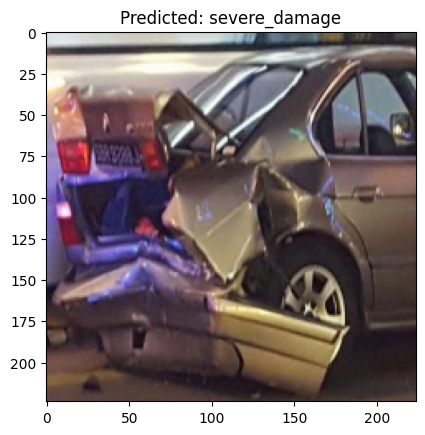

1/1 [==============================] - 0s 11ms/step


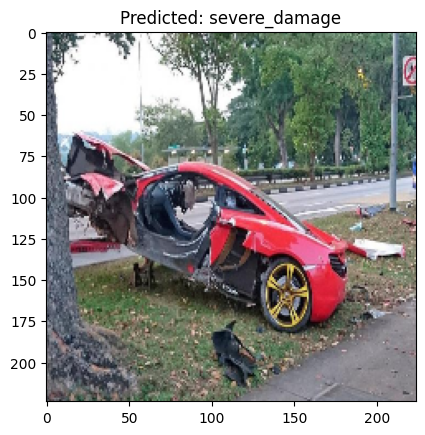

1/1 [==============================] - 0s 12ms/step


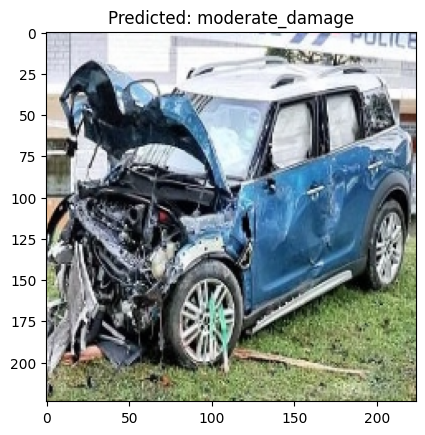

1/1 [==============================] - 0s 11ms/step


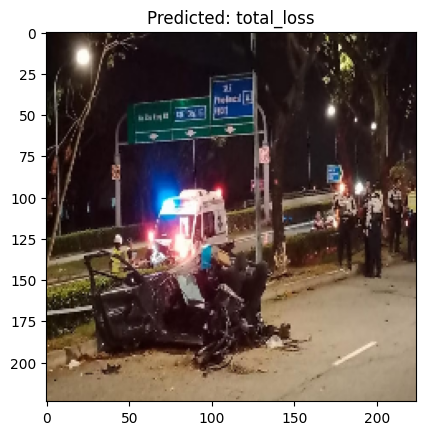

1/1 [==============================] - 0s 12ms/step


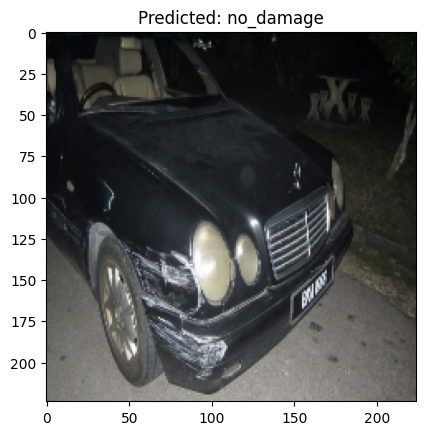

1/1 [==============================] - 0s 12ms/step


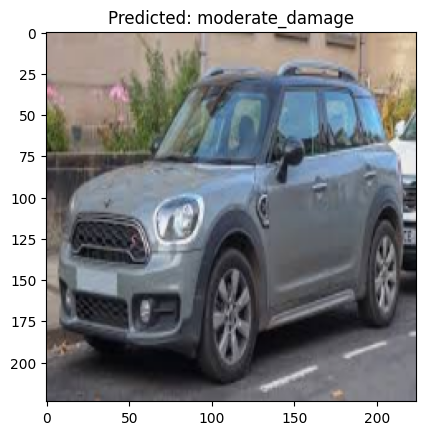

1/1 [==============================] - 0s 37ms/step


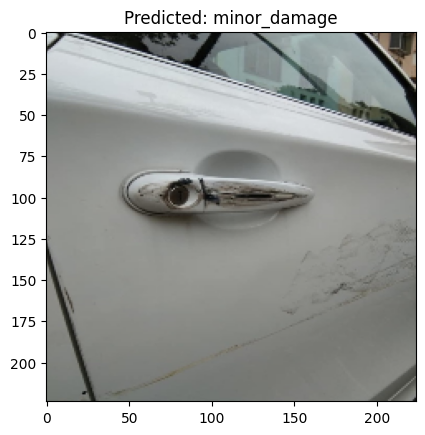

1/1 [==============================] - 0s 12ms/step


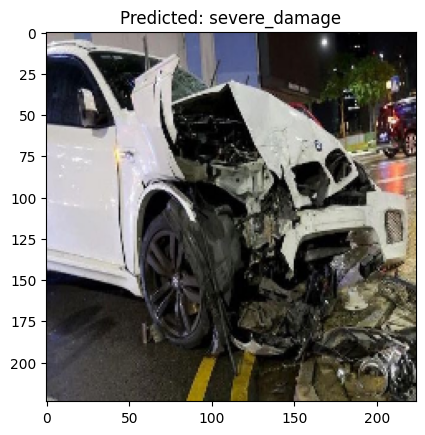

1/1 [==============================] - 0s 11ms/step


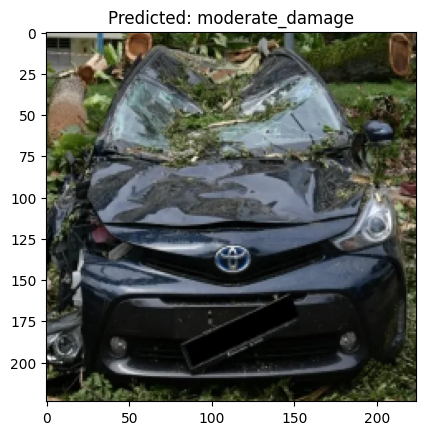

1/1 [==============================] - 0s 16ms/step


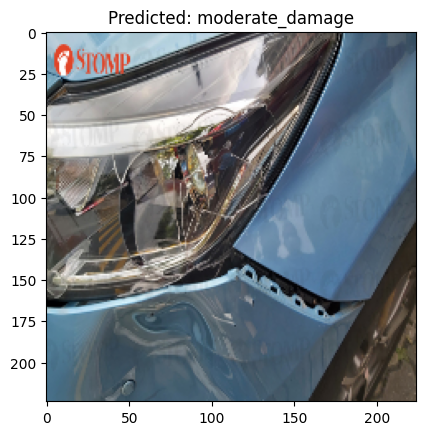

1/1 [==============================] - 0s 28ms/step


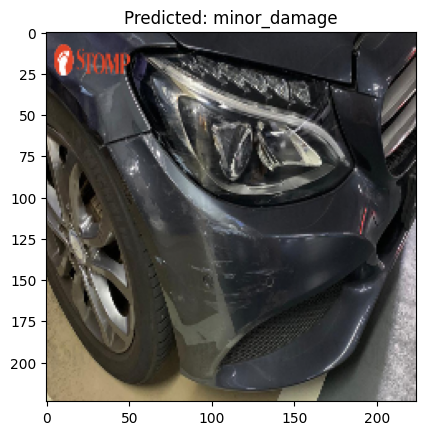

1/1 [==============================] - 0s 11ms/step


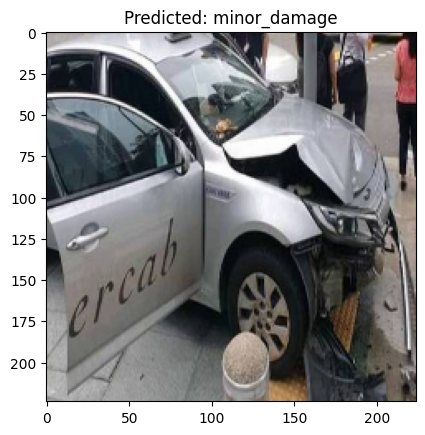

1/1 [==============================] - 0s 11ms/step


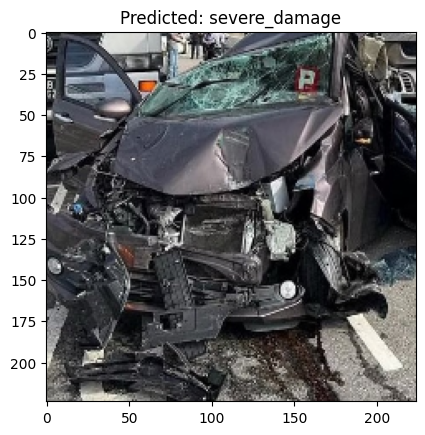

1/1 [==============================] - 0s 29ms/step


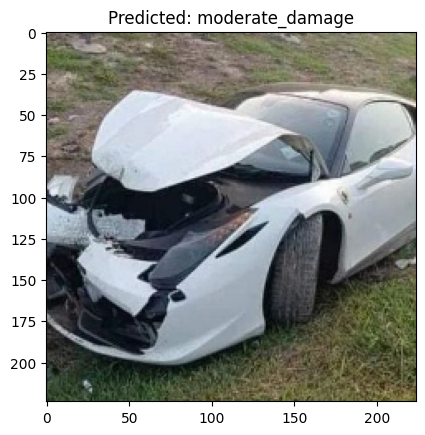

1/1 [==============================] - 0s 11ms/step


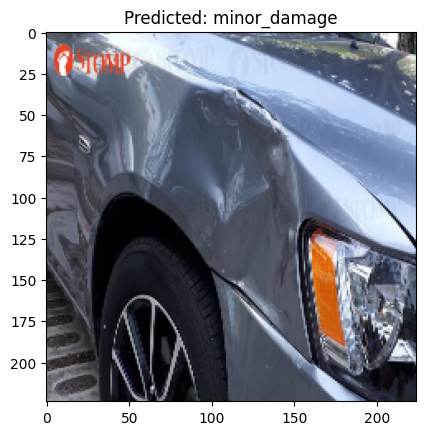

1/1 [==============================] - 0s 11ms/step


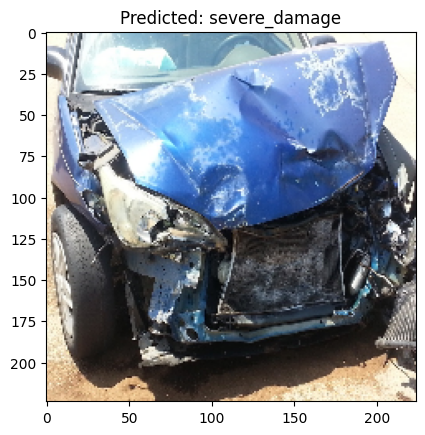

1/1 [==============================] - 0s 12ms/step


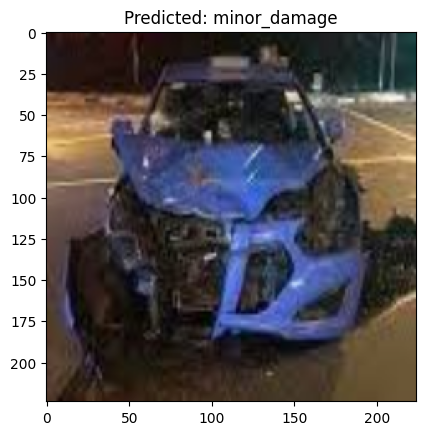

1/1 [==============================] - 0s 13ms/step


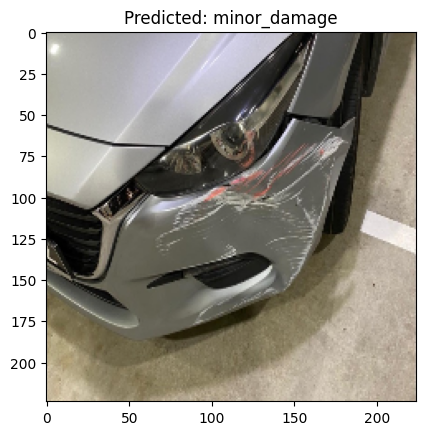

1/1 [==============================] - 0s 12ms/step


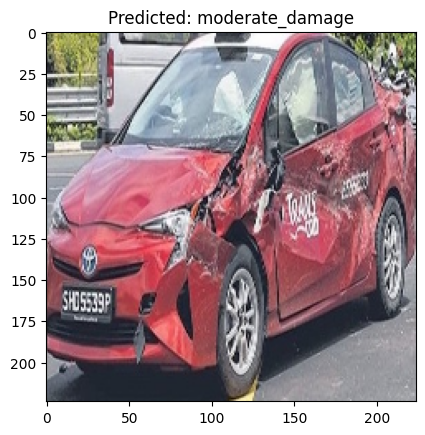

1/1 [==============================] - 0s 12ms/step


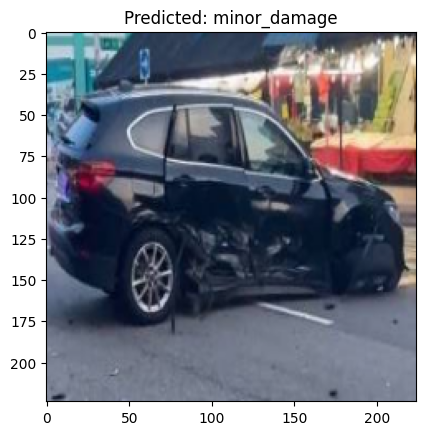

1/1 [==============================] - 0s 12ms/step


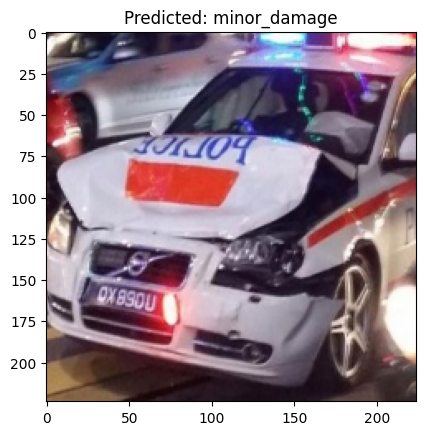

1/1 [==============================] - 0s 33ms/step


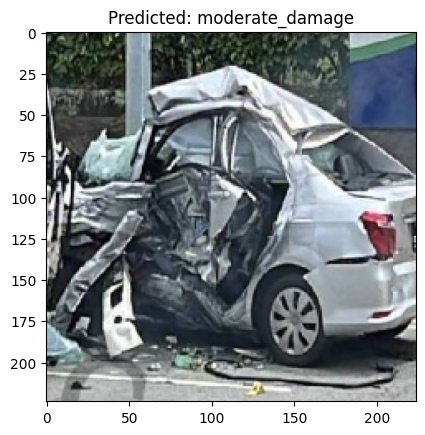

1/1 [==============================] - 0s 26ms/step


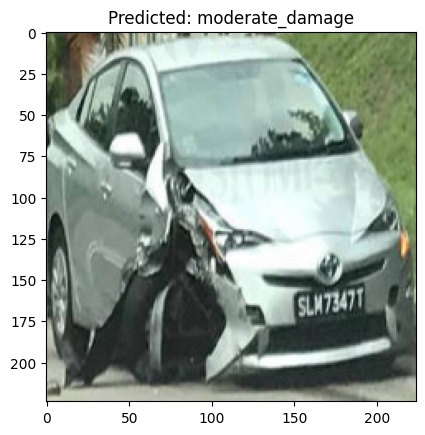

1/1 [==============================] - 0s 12ms/step


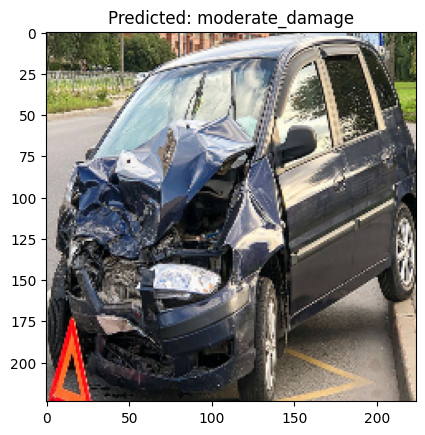

1/1 [==============================] - 0s 31ms/step


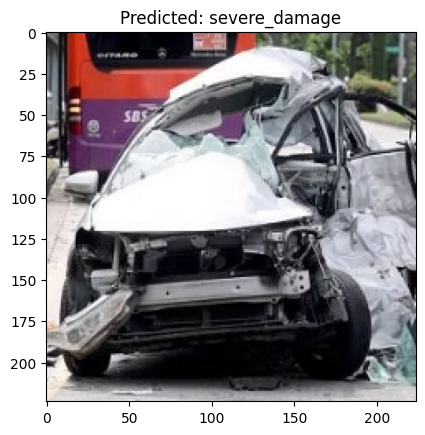

1/1 [==============================] - 0s 12ms/step


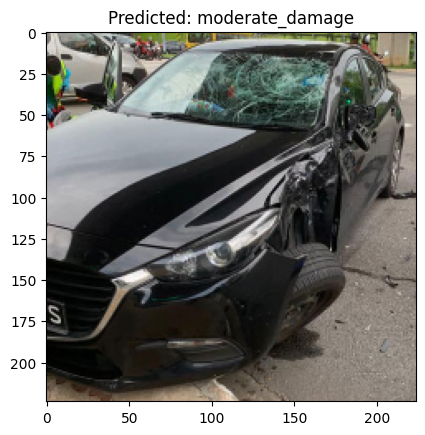

1/1 [==============================] - 0s 12ms/step


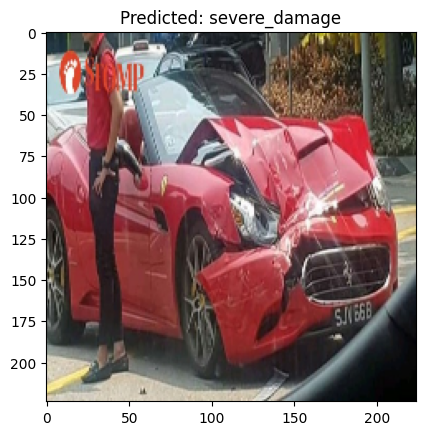

1/1 [==============================] - 0s 30ms/step


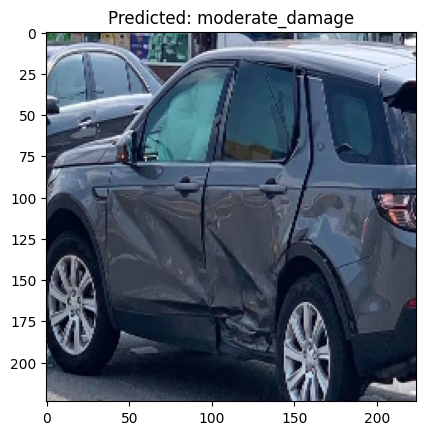

1/1 [==============================] - 0s 26ms/step


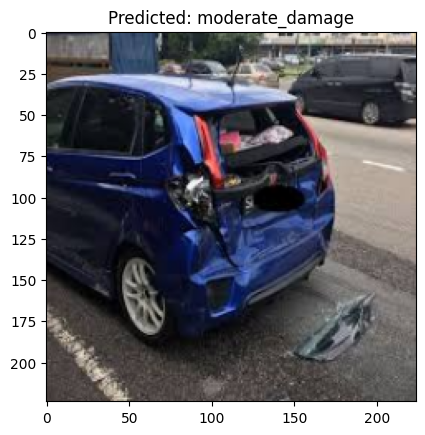

1/1 [==============================] - 0s 11ms/step


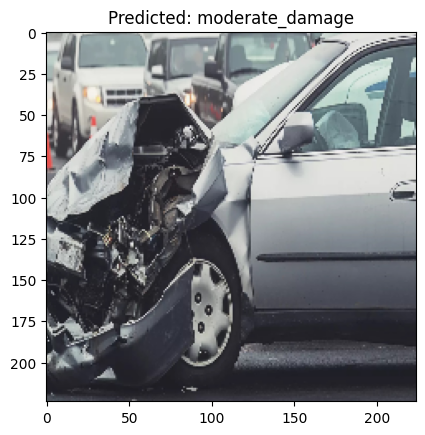

In [25]:
# Predict 

predict_dir = "/Users/mckishiebombom/code/quekwl/car_damage_assessment/predict_02"
predict_list = remove_hidden(predict_dir)
print(len(predict_list))
print(class_names)


# Loop through predict folder
for image in predict_list:
       
    # Read image
    image_path = os.path.join(predict_dir, image)
    image = cv2.imread(image_path)
    
    image = cv2.resize(image, (224, 224))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    # Predict
    image = np.expand_dims(image, axis=0)
    result = custom_model_vgg16.predict(image)
    
    # Print results
    plt.imshow(image_rgb)
    plt.title(f"Predicted: {class_names[np.argmax(result)]}")
    plt.show()
    # print(class_names[np.argmax(result)])

In [26]:
class_names

['moderate_damage', 'no_damage', 'severe_damage', 'minor_damage', 'total_loss']

In [27]:
predict_list

['car_28.jpg',
 'car_29.jpg',
 'car_15.jpg',
 'car_8.jpg',
 'car_39.jpg',
 'car_38.jpg',
 'car_9.jpg',
 'car_12.jpg',
 'car_13.jpg',
 'car_36.jpg',
 'car_22.jpg',
 'car_23.jpg',
 'car_37.jpg',
 'car_6.jpg',
 'car_4.jpg',
 'car_21.jpg',
 'car_35.jpg',
 'car_34.jpg',
 'car_1.jpg',
 'car_18.jpg',
 'car_24.jpg',
 'car_30.jpg',
 'car_31.jpg',
 'car_25.jpg',
 'car_19.jpg',
 'car_2.jpg',
 'car_33.jpg',
 'car_26.jpg',
 'car_32.jpg',
 'car_3.jpg',
 'car_7 copy.jpg']